In [1]:
%matplotlib inline


Creative AI
============================






In [2]:
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

Cuda
~~~~




In [3]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [4]:
print(use_cuda)

False


Loading images images
~~~~~~~~~~~



In [6]:
# desired size of the output image
imsize = 512 if use_cuda else 128

loader = transforms.Compose([
    transforms.Scale(imsize),  # scaling
    transforms.ToTensor()])  # torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))

    image = image.unsqueeze(0)
    return image


style_img = image_loader("images/picasso.jpg").type(dtype)
content_img = image_loader("images/dancing.jpg").type(dtype)

assert style_img.size() == content_img.size(), \
    "same size"

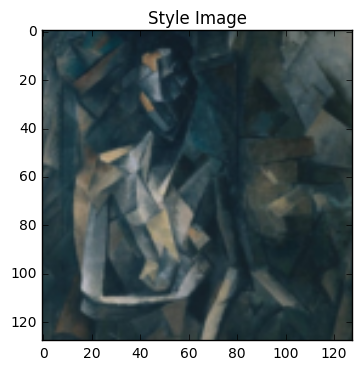

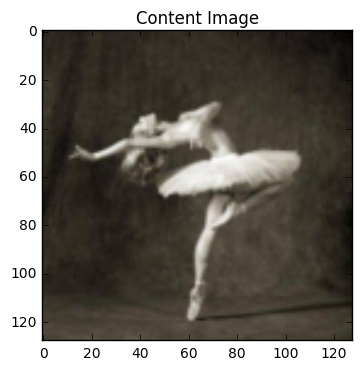

In [7]:
unloader = transforms.ToPILImage()  # reconverting into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu() 
    image = image.view(3, imsize, imsize) 
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

Content loss
~~~~~~~~~~~~




In [8]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
       
        self.target = target.detach() * weight
       
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

Content Loss

Style loss
~~~~~~~~~~





In [9]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size() 
        # b=number of feature maps
     

        features = input.view(a * b, c * d) 

        G = torch.mm(features, features.t()) 

        return G.div(a * b * c * d)

In [10]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

Load the neural network
~~~~~~~~~~~~~~~~~~~~~~~






In [11]:
cnn = models.vgg19(pretrained=True).features


if use_cuda:
    cnn = cnn.cuda()

In [12]:

content_layers_default = ['conv_2']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

   
    content_losses = []
    style_losses = []

    model = nn.Sequential()  
    gram = GramMatrix() 


    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses

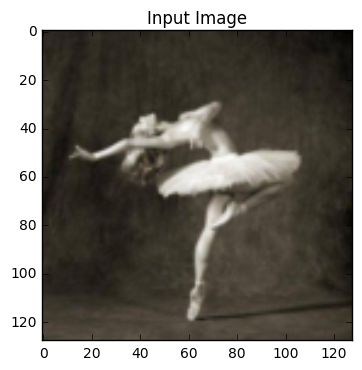

In [13]:
input_img = content_img.clone()



plt.figure()
imshow(input_img.data, title='Input Image')

Gradient descent
~~~~~~~~~~~~~~~~






In [14]:
def get_input_param_optimizer(input_img):

    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [15]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    """Artfying."""
    print('Building the style  model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            
            input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()

            return style_score + content_score

        optimizer.step(closure)

   
    input_param.data.clamp_(0, 1)

    return input_param.data

Final Run

Building the style  model..
Optimizing..
run [50]:
Style Loss : 0.788054 Content Loss: 1.005851

run [100]:
Style Loss : 0.269263 Content Loss: 0.865007

run [150]:
Style Loss : 0.226399 Content Loss: 0.823029

run [200]:
Style Loss : 0.209633 Content Loss: 0.806625

run [250]:
Style Loss : 0.204315 Content Loss: 0.795387

run [300]:
Style Loss : 0.200760 Content Loss: 0.790161



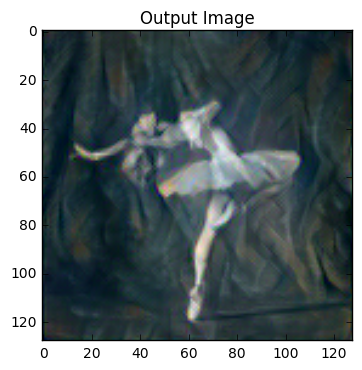

In [16]:
output = run_style_transfer(cnn, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()